In [102]:
! python3 -m pip install -r "garbage-detection/standalone_processing/requirements.txt"

Execute error: Servant c1.4 not allocated: Internal Error

In [1]:
from collections import defaultdict
import torch

import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.exposure import rescale_intensity
import os

from glob import glob

from tqdm.auto import tqdm

import hydra
from omegaconf import DictConfig, OmegaConf
import re
import yaml

import cv2

import imgviz
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet
import torch

import pandas as pd

In [25]:
! python3 -m pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [22]:
! python3 -m pip install protobuf==4.21.6

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.5 requires protobuf<=3.20.1, but you have protobuf 4

In [23]:
! python3 -m pip install pytorch-lightning==2.1.2

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pytorch-lightning==2.1.2 from https://files.pythonhosted.org/packages/60/eb/f29a4511a2675c9c14ca31cde4562f7676cf70396cf9e599210dca2f1e66/pytorch_lightning-2.1.2-py3-none-any.whl.metadata
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.6.5
    Uninstalling pytorch-lightning-1.6.5:
      Successfully uninstalled pytorch-lightning-1.6.5


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torchaudio

In [3]:
import pytorch_lightning as pl

In [4]:
from torch.optim import Adam
from pytorch_lightning import LightningModule

In [5]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [6]:
define_nearest_crop = lambda x: int((x // 32) * 32)
is_img = re.compile('^.*.(jpg|jpeg|png|tif|tiff)', flags=re.IGNORECASE)

In [7]:
classes_names = ['log', 'plastic']

In [8]:
image_template = '/home/jupyter/mnt/s3/garbage-data/old-labeling/unziped/data/{}_image.jpg'
human_template = '/home/jupyter/mnt/s3/garbage-data/old-labeling/unziped/result/{}_human.png'
nature_template = '/home/jupyter/mnt/s3/garbage-data/old-labeling/unziped/result/{}_nature.png'

def _load_one_image(img_addr):
    try:
        img = imread(img_addr)
    except:
        return None, False
    img = np.moveaxis(img, -1, 0)
    img = img[..., :define_nearest_crop(img.shape[-2]), :define_nearest_crop(img.shape[-1])]
    img = torch.FloatTensor(img / 255)[None, ...]
    return img, True

def num_to_path(i: int):
    if i < 10:
        return f"00{i}"
    if i < 100:
        return f"0{i}"
    return f"{i}"

def load_batch(indices):
    imgs = []
    human_imgs = []
    nature_imgs = []
    
    for i in indices:
        path = num_to_path(i)
        img, ok1 = _load_one_image(image_template.format(path))
        human, ok2 = _load_one_image(human_template.format(path))
        nature, ok3 = _load_one_image(nature_template.format(path))
        if not ok1:
            continue
        if not ok2 and not ok3:
            continue
        
        if not ok2:
            human = torch.zeros_like(nature)
        if not ok3:
            nature = torch.zeros_like(human)
        
        imgs.append(img)
        human_imgs.append(img)
        nature_imgs.append(img)
    
    imgs_batch = torch.cat(imgs, dim=0)
    human_batch = torch.cat(human_imgs, dim=0)
    nature_batch = torch.cat(nature_imgs, dim=0)
    
    print(f"Imgs batch shape: {imgs_batch.shape}")
    print(f"Human batch shape: {human_batch.shape}")
    print(f"Nature batch shape: {nature_batch.shape}")
    return imgs_batch, human_batch, nature_batch

In [9]:
valid_indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

In [10]:
len(valid_indices)

53

In [11]:
train_indices = valid_indices[:30]
val_indices = valid_indices[30:41]
test_indices = valid_indices[41:]

In [19]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        indices,
    ):
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        ind = self.indices[index]
        path = num_to_path(ind)
        img, ok1 = _load_one_image(image_template.format(path))
        human, ok2 = _load_one_image(human_template.format(path))
        nature, ok3 = _load_one_image(nature_template.format(path))
        assert ok1
        assert ok2 or ok3
        
        if not ok2:
            human = torch.zeros_like(nature)
        if not ok3:
            nature = torch.zeros_like(human)
            
        nature_class = nature[:, 0:1, :, :] # оставляем только нулевой канал
        human_class = human[:, 0:1, :, :] # оставляем только нулевой канал

        cat = torch.cat((nature_class, human_class), dim=1)
        neutral = 1. - torch.max(cat, dim=1).values.unsqueeze(0)
        mask = torch.cat((neutral, nature_class, human_class), dim = 1).round()
        
        # print(f"dataset: img shape: {img.shape}, mask shape: {mask.shape}")
        
        return {"image": img[0], "mask": mask[0]}

In [20]:
BATCH_SIZE = 1

train_dataset = SegmentationDataset(train_indices)
val_dataset = SegmentationDataset(val_indices)
test_dataset = SegmentationDataset(test_indices)

n_cpu = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=n_cpu)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

In [21]:
import smp_metrics
from segmentation_models_pytorch import Unet

In [22]:
class GarbageDetectionUnetModel(LightningModule):

    def __init__(self, in_channels, classes, encoder_name = "resnet18", **kwargs):
        super().__init__()
        self.model = Unet(encoder_name=encoder_name, in_channels=in_channels, classes=classes)

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        
        # Loss multilabel mode suppose you are solving multi-label segmentation task. 
        # That mean you have C = 1..N classes which pixels are labeled as 1,
        # classes are not mutually exclusive and each class have its own channel,
        # pixels in each channel which are not belong to class labeled as 0. 
        # Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
        
        self.step_outputs = {
            "train": [],
            "valid": [],
            "test": [],
        }

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]
        # print(f"shared_step: img shape: {image.shape}")

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        # print(f"shared_step: mask shape: {mask.shape}")

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        # Logits are the vector of raw (non-normalized) predictions that a classification model generates,
        # which is ordinarily then passed to a normalization function. 
        # If the model is solving a multi-label classification problem,
        # logits typically become an input to the softmax function. 
        # The softmax function then generates a vector of (normalized) probabilities with one value for each possible class
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics
        predicted_class = logits_mask.argmax(dim=1)
        # one-hot encoding
        one_hot = torch.nn.functional.one_hot(predicted_class, num_classes=len(classes_names)+1).permute(0, 3, 1, 2)
        pred_mask = one_hot
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp_metrics.get_stats(pred_mask.long(), mask.long(), mode=smp.losses.MULTILABEL_MODE)

        self.step_outputs[stage].append({
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        })
        
        return loss
            
    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp_metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp_metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_training_epoch_end(self):
        stage="train"
        outputs = self.step_outputs[stage]
        res = self.shared_epoch_end(outputs, stage)
        self.step_outputs[stage].clear()
        return res

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        stage="valid"
        outputs = self.step_outputs[stage]
        res = self.shared_epoch_end(outputs, stage)
        self.step_outputs[stage].clear()
        return res

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        stage="test"
        outputs = self.step_outputs[stage]
        res = self.shared_epoch_end(outputs, stage)
        self.step_outputs[stage].clear()
        return res

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [23]:
model = GarbageDetectionUnetModel(in_channels=3, classes=len(classes_names) + 1)

In [24]:
trainer = pl.Trainer( 
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 14.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.314    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
from pprint import pprint

In [27]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_dataset_iou': 0.6835156083106995,
  'valid_per_image_iou': 0.6939858198165894}]


In [28]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_dataset_iou': 0.6951606273651123,
  'test_per_image_iou': 0.7115195989608765}]


In [36]:
model.eval()

GarbageDetectionUnetModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [37]:
batch = test_dataset[0]

In [38]:
batch["image"].shape

torch.Size([3, 1792, 2688])

In [40]:
import numpy as np
import skimage

with torch.no_grad():
    model.eval()
    logits = model(batch["image"].unsqueeze(0))
    
pred = logits[0].detach().cpu().numpy().argmax(0)   

res = skimage.color.label2rgb(pred, image=np.moveaxis((batch["image"].detach().cpu().numpy() * 255).astype(np.uint8), 0, -1))

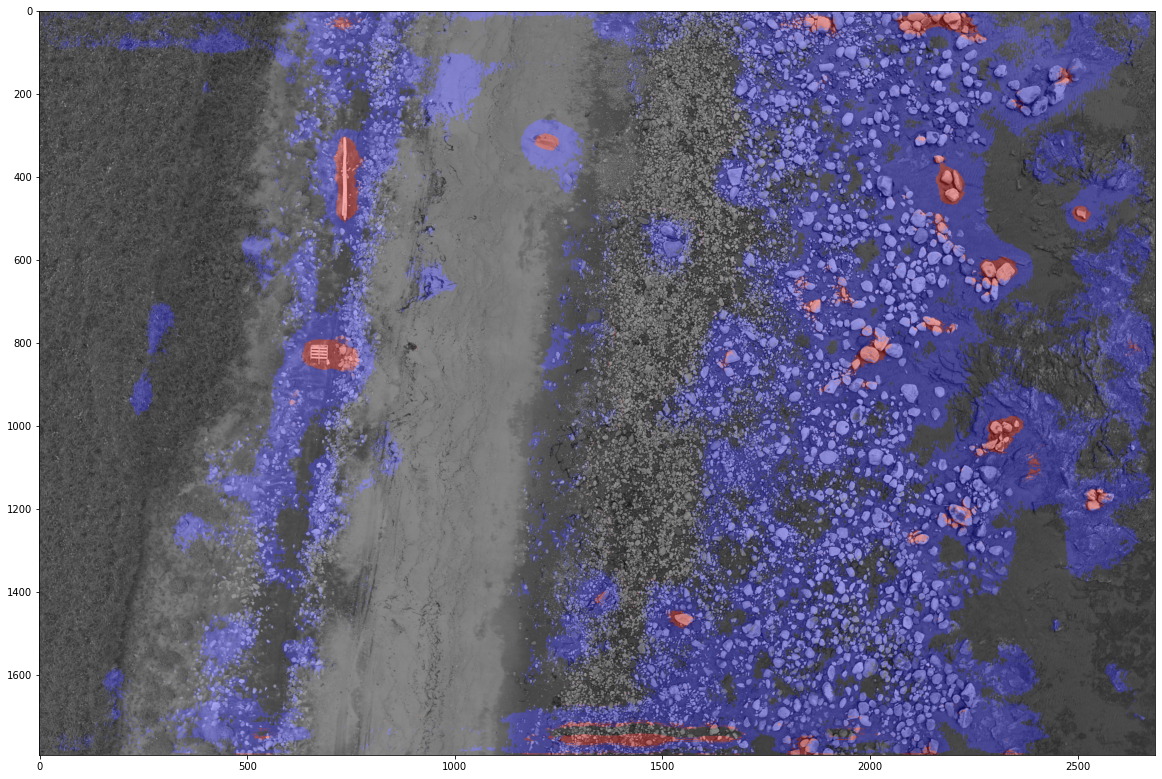

In [41]:
from matplotlib import pyplot as plt

plt.figure(figsize = (20, 20 * res.shape[1] / res.shape[0]))
imgplot = plt.imshow(res)
plt.show()

In [42]:
secondmodel = GarbageDetectionUnetModel.load_from_checkpoint("/home/jupyter/datasphere/project/lightning_logs/version_8/checkpoints/epoch=4-step=150.ckpt", in_channels=3, classes=len(classes_names) + 1)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
import numpy as np
import skimage

with torch.no_grad():
    secondmodel.eval()
    logits = secondmodel(batch["image"].unsqueeze(0).to(device))
    
pred = logits[0].detach().cpu().numpy().argmax(0)   

res = skimage.color.label2rgb(pred, image=np.moveaxis((batch["image"].detach().cpu().numpy() * 255).astype(np.uint8), 0, -1))

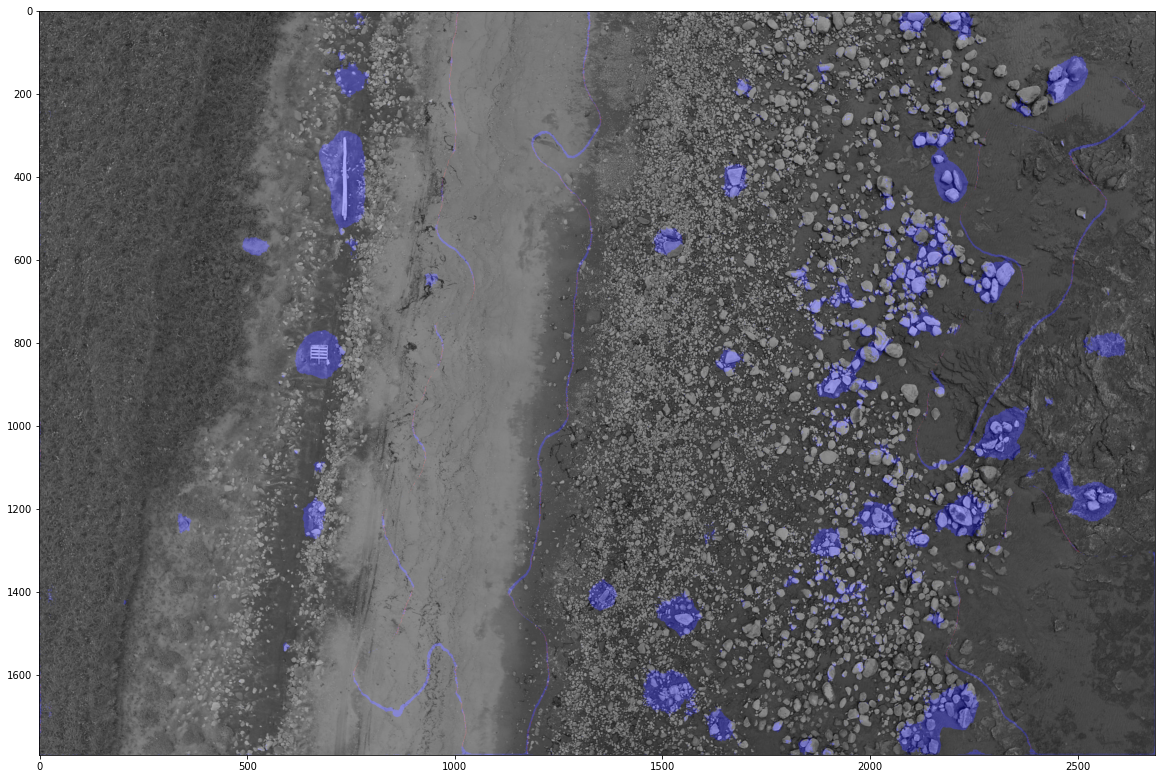

In [48]:
from matplotlib import pyplot as plt

plt.figure(figsize = (20, 20 * res.shape[1] / res.shape[0]))
imgplot = plt.imshow(res)
plt.show()